## Access Vessel SST Delayed QC data in Parquet

A jupyter notebook to show how to access and plot Vessel SST Delayed QC data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/67f0b6ea-518f-4af5-9d21-dd3c08c7cb5c).

In [1]:
dataset_name = "vessel_sst_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 60ms


In [3]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

timestamp: int32
polygon: string
platform_code: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'platform_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['HSB3402', 'FHZI']
CPU times: user 3.41 ms, sys: 2.73 ms, total: 6.14 ms
Wall time: 5.24 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


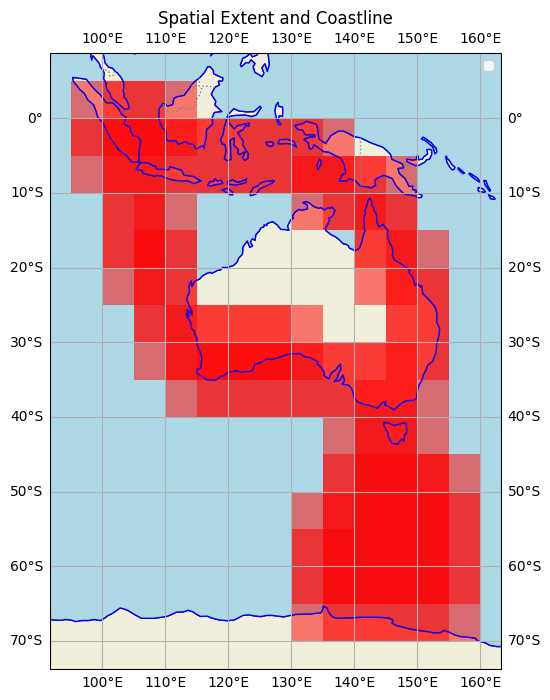

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [9]:
get_temporal_extent(parquet_ds)

(Timestamp('2008-10-21 00:00:00'), Timestamp('2013-04-12 23:59:00.000003584'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comment': 'Relative julian days with decimal part as parts of the day',
  'ancillary_variables': 'TIME_quality_control'},
 'LATITUDE': {'type': 'double',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'instrument': 'unknown',
  'observation_type': 'measured',
  'standard_name': 'latitude',
  'axis': 'Y',
  'valid_min': -90,
  'valid_max': 90,
  'reference_datum': 'geographical coordinates, WGS84',
  'ancillary_variables': 'LATITUDE_quality_control'},
 'LONGITUDE': {'type': 'double',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'instrument': 'unknown',
  'observation_type': 'measured',
  'standard_name': 'longitude',
  'axis': 'X',
  'valid_min': -180,
  'valid_max': 180,
  'reference_datum': 'geographical coordinates, WGS84',
  'ancillary_variables': 'LONGITUDE_quality_control'},
 'TEMP': {'type': 'float',
  'long_name': 

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2012-12-23 10:14:00', date_end='2013-04-01 07:50:00')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262900 entries, 0 to 262899
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   TIME                       262900 non-null  datetime64[ns]
 1   LATITUDE                   262900 non-null  float64       
 2   LONGITUDE                  262900 non-null  float64       
 3   TEMP                       259220 non-null  float32       
 4   history                    262900 non-null  object        
 5   TIME_quality_control       262900 non-null  object        
 6   LATITUDE_quality_control   262900 non-null  object        
 7   LONGITUDE_quality_control  262900 non-null  object        
 8   TEMP_quality_control       262900 non-null  object        
 9   AIRT_quality_control       0 non-null       object        
 10  WSPD                       0 non-null       float32       
 11  WSPD_quality_control       0 non-null       object  

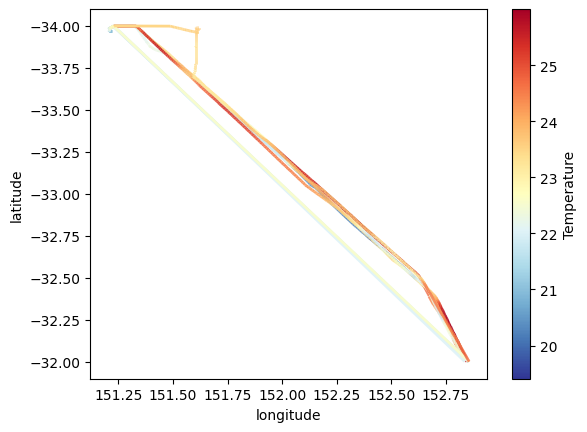

In [13]:
df_sorted = df.sort_values('TIME')

# Create a list of segments
points = np.array([df_sorted['LONGITUDE'], df_sorted['LATITUDE']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments colored by temperature
norm = plt.Normalize(df_sorted['TEMP'].min(), df_sorted['TEMP'].max())
lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
lc.set_array(df_sorted['TEMP'])
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_xlabel(metadata['LONGITUDE']['standard_name'])
ax.set_ylabel(metadata['LATITUDE']['standard_name'])
ax.invert_yaxis()

# Adding color bar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Temperature')

plt.show()

## Create a TIME and scalar/number filter

In [14]:
filter_time = create_time_filter(parquet_ds, date_start='2010-01-31 10:14:00', date_end='2010-02-01 07:50:00')

expr_1 = pc.field('platform_code') == pa.scalar("FHZI")
filter = expr_1 & filter_time

In [15]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   TIME                       25920 non-null  datetime64[ns]
 1   LATITUDE                   25920 non-null  float64       
 2   LONGITUDE                  25920 non-null  float64       
 3   TEMP                       25920 non-null  float32       
 4   history                    25920 non-null  object        
 5   TIME_quality_control       25920 non-null  object        
 6   LATITUDE_quality_control   25920 non-null  object        
 7   LONGITUDE_quality_control  25920 non-null  object        
 8   TEMP_quality_control       25920 non-null  object        
 9   AIRT_quality_control       25920 non-null  object        
 10  WSPD                       25920 non-null  float32       
 11  WSPD_quality_control       25920 non-null  object        
 12  WDIR

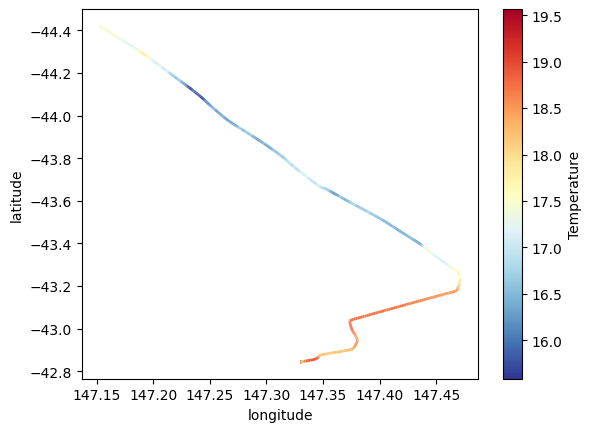

In [16]:
df_sorted = df.sort_values('TIME')

# Create a list of segments
points = np.array([df_sorted['LONGITUDE'], df_sorted['LATITUDE']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments colored by temperature
norm = plt.Normalize(df_sorted['TEMP'].min(), df_sorted['TEMP'].max())
lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
lc.set_array(df_sorted['TEMP'])
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_xlabel(metadata['LONGITUDE']['standard_name'])
ax.set_ylabel(metadata['LATITUDE']['standard_name'])
ax.invert_yaxis()

# Adding color bar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Temperature')

plt.show()